# Using Keras to train MixtureOfSVGPExperts on the Quadcopter Data Set

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using `MixtureOfSVGPExperts`) on the motorcycle data set. It shows how to instantiate the model in the special two expert case when only a single gating function is needed (not two!) and the gating network can be calculated in closed form. It then shows how to save and load the model using Keras. Finally, it shows how to instantiate and train the model in the general case with more that two experts.

In [ ]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

from gpflow import default_float
from gpflow.models import SVGP
from gpflow.utilities import print_summary

from mogpe.keras.experts import SVGPExpert
# from mogpe.keras.gps import SVGPPrior
from mogpe.keras.gating_networks import SVGPGatingNetwork
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting.quadcopter_plotter import QuadcopterPlotter
from mogpe.keras.utils import model_from_yaml

Let's start by loading the motorcycle dataset and plotting it to see what we're dealing with.

In [ ]:
def load_quadcopter_dataset(filename, trim_coords = None, standardise = True):
    data = np.load(filename)
    X = data["x"]
    Y = data["y"][:, 0:2]
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    if standardise:
        X = (X - X.mean()) / X.std()
        Y = (Y - Y.mean()) / Y.std()

    # remove some data points
    def trim_dataset(X, Y, trim_coords):
        mask_0 = X[:, 0] < trim_coords[0][0]
        mask_1 = X[:, 1] < trim_coords[0][1]
        mask_2 = X[:, 0] > trim_coords[1][0]
        mask_3 = X[:, 1] > trim_coords[1][1]
        mask = mask_0 | mask_1 | mask_2 | mask_3
        return X[mask, :], Y[mask, :]

    X, Y = trim_dataset(X, Y, trim_coords)
    print("Trimmed input data shape: ", X.shape)
    print("Trimmed output data shape: ", Y.shape)

    return X, Y

In [ ]:
# data_file = "./quadcopter/data/quadcopter_data_step_10_direction_down.npz"
data_file = "../data/quadcopter_data_step_20_direction_down.npz"
# data_file = "./quadcopter/data/quadcopter_data_step_40_direction_down.npz"
trim_coords = [[-1.5, -3.0], [1.5, 0.0]]
standardise = True  # true/false whether to standardise data
X, Y = load_quadcopter_dataset(filename=data_file, trim_coords=trim_coords, standardise=standardise)

In [ ]:
num_data, input_dim = X.shape
output_dim = Y.shape[1]
plt.quiver(X[:, 0], X[:, 1], Y[:, 0], Y[:, 1])

In [5]:
num_experts = 2
# experts_lengthscales = [1.0, 1.0]  # lengthsales for expert 1 and 2
# experts_lengthscales = [1.0, 10.0]  # lengthsales for expert 1 and 2
num_inducing_expert = 80  # number of inducing points for each expert
num_inducing_gating = 100  # number of inducing points for gating network

In order to initialie the `MixtureOfSVGPExperts` class we must pass it a list of `SVGPExpert` instances and an instance of `SVGPGatingNetwork`. Let's start by creating the list of experts. To do this we create a `Likelihood` and `SVGPPrior` for each expert.

In [6]:
def sample_inducing_inputs_from_data(X, num_inducing):
    idx = np.random.choice(range(X.shape[0]), size=num_inducing, replace=False) 
    return X[idx, ...].reshape(-1, input_dim)

def sample_inducing_variable_from_data(X, num_inducing):
    inducing_inputs = sample_inducing_inputs_from_data(X, num_inducing)
    return gpf.inducing_variables.InducingPoints(inducing_inputs)

def init_expert(lengthscales=[1.0, 1.0], kernel_variance=1.0, noise_variance=[1.0]):
    inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(sample_inducing_variable_from_data(X, num_inducing_gating))
    mean_function = gpf.mean_functions.Constant([0.0]*output_dim)
    likelihood = gpf.likelihoods.Gaussian(noise_variance*output_dim)
    kernel_list = [gpf.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance) for _ in range(output_dim)]
    kernel = gpf.kernels.SeparateIndependent(kernel_list)
    return SVGPExpert(kernel, 
                      likelihood=likelihood, 
                      inducing_variable=inducing_variable, 
                      mean_function=mean_function,
                      num_latent_gps=output_dim)

In [7]:
experts_list = [init_expert() for k in range(num_experts)]

2022-02-15 15:08:32.982124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Lovely stuff. We now need to create an instance of `SVGPGatingNetwork`. Remember that we only need a single gating function for the two expert case. Let's go ahead and create a single gating function and use it to construct our gating network. The `SVGPGatingNetwork` constructor accepts a `SVGPPrior` instance and uses it to select the right likelihood. It selects the `Bernoulli` likelihood if the `SVGPPrior` has a single output and selects the `Softmax` likelihood in the general case when a multioutput `SVGPPrior` (where each output dimension corresponds to a gating function).

In [8]:
def init_gating_network(num_gating_gps=1):
    if num_gating_gps == 1:
        inducing_variable = sample_inducing_variable_from_data(X, num_inducing_gating)
        kernel = gpf.kernels.RBF()
    else:
        kernel = gpf.kernels.SeparateIndependent([gpf.kernels.RBF() for _ in range(num_gating_gps)])
        inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(sample_inducing_variable_from_data(X, num_inducing_gating))
    return SVGPGatingNetwork(kernel=kernel, mean_function=gpf.mean_functions.Zero(), inducing_variable=inducing_variable)

In [9]:
gating_network = init_gating_network()
# print_summary(gating_network, fmt="notebook")

We now have all the components to construct our `MixtureOfSVGPExperts` model so let's go ahead and do it.

In [10]:
model = MixtureOfSVGPExperts(experts_list=experts_list, 
                             gating_network=gating_network, 
                             num_data=X.shape[0], 
                             num_samples=1,
                             bound="further_gating")
# print_summary(model, fmt="notebook")

We can use the Plotter1D class from `mogpe.helpers.plotter` to plot our model before training.  
- The top plot shows mixing probablility for each expert,
- Middle plots show each experts latent GP,
- The bottom plot shows the models posterior with the mean (black line) and samples (green dots).

In [11]:
import palettable
cmap = palettable.scientific.sequential.Bilbao_15.mpl_colormap
figsize = (12, 4)
num_test = 400
factor = 1.2
sqrtN = int(np.sqrt(num_test))
xx = np.linspace(tf.reduce_min(X[:, 0]) * factor, np.max(X[:, 0]) * factor, sqrtN)
yy = np.linspace(tf.reduce_min(X[:, 1]) * factor, np.max(X[:, 1]) * factor, sqrtN)
xx, yy = np.meshgrid(xx, yy)
test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])


def plot_contf(ax, z):
    contf = ax.tricontourf(test_inputs[:, 0], test_inputs[:, 1], z, levels=10, cmap=cmap)
    return contf

def plot_gp(axs, mean, var):
    axs[0].set_title('Mean')
    axs[1].set_title('Variance')
    return plot_contf(axs[0], mean), plot_contf(axs[1], var)

def plot_gating_network(gating_network):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(num_experts, 2, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.suptitle("Gating GPs")
    h_means, h_vars = gating_network.predict_h(test_inputs)
    for k in range(num_experts):
        plot_gp(axs[k, :], h_means[:, k], h_vars[:, k])
    mixing_probs = gating_network.predict_mixing_probs(test_inputs)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Mixing Probabilities")
    gs = fig.add_gridspec(1, num_experts, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    for k in range(num_experts):
        plot_contf(axs[k], mixing_probs[:, k])
        axs[k].set_title('Expert {}'.format(k+1))

def plot_expert(expert, k):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Expert {} Latent Function GPs".format(k+1))
    gs = fig.add_gridspec(output_dim, 2, wspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    f_means, f_vars = expert.predict_f(test_inputs)
    for j in range(output_dim):
        plot_gp(axs[j,:], f_means[:, j], f_vars[:, j])
        
def plot_experts(experts_list):
    for k, expert in enumerate(experts_list):
        plot_expert(expert, k)
        
def plot_model(model):
    plot_gating_network(model.gating_network)
    plot_experts(model.experts_list)

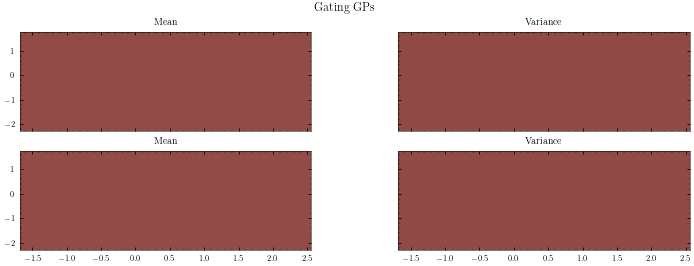

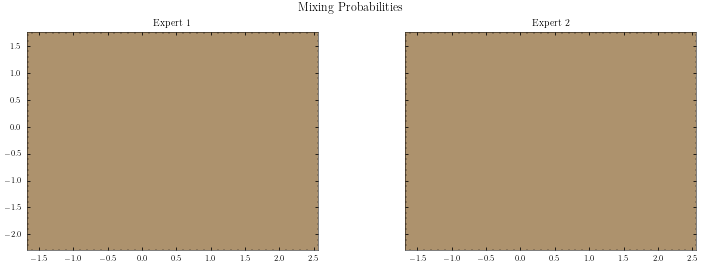

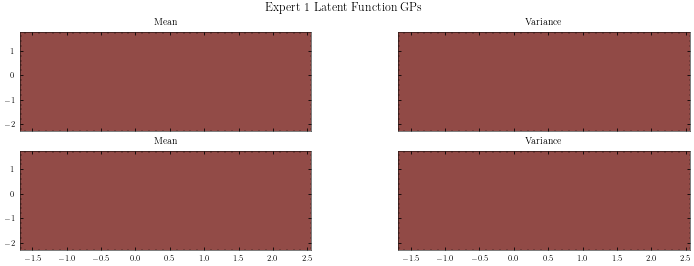

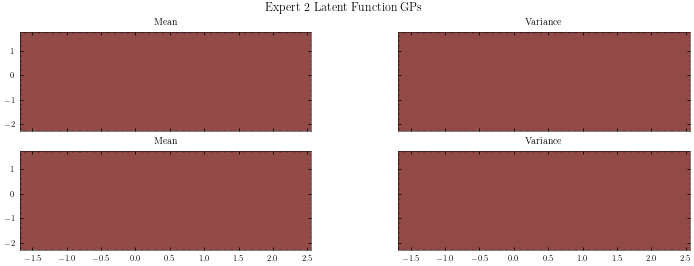

In [12]:
# plotter = QuadcopterPlotter(model, X, Y)
# plotter.plot_model(save_dir="./images")
plot_model(model)

Keras makes training/checkpointing/saving/loading the model super easy! This is the main reason I wanted to use keras. We first configure the training/logging parameters. We will use the Adam optimizer to train the model with SGD. Let's now specify the relevant training parameters.

In [13]:
num_epochs = 5000
batch_size = 16
learning_rate = 0.01
num_samples = 1  # number of samples to draw from variational posterior in ELBO
ckpt_dir = "./ckpts"
log_dir = "./logs"

We can easily use keras callbacks to monitor the model in TensorBorad and checkpoint the model during training.

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer)

In [ ]:
history = model.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

In [ ]:
def plot_elbo(negative_elbo):
    plt.subplot(111)
    plt.scatter(np.arange(len(negative_elbo)), negative_elbo)
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO")
plot_elbo(history.history["loss"])
# print_summary(expert, fmt="notebook")

Now that we have trained the model we can use our plotter again to visualise what we have learned.

In [ ]:
plot_model(model)

## Saving/Loading

The model can easily be saved using keras as I have implemented the `get_config`/`from_config` methods for all components of the model (including some GPflow kernels/mean_functions/likelihoods/inducing_variables). Let's save the model...

In [ ]:
save_dir = "./saved_models/two_experts"
model(X)
model.save(save_dir)

The saved model can then be loaded in multiple ways using Keras,
1. Load the saved model with its `call` method but no other attributes/methods. This can get you out of tricky situations, when the code base has changed and keras cannot instantiate the model using the `get_config`/`from_config` methods. The model can still make predictions but it is not a instance of its original class so does not have its attributes and methods, just its `call` function.
2. Instantiate the models class using the saved config files.

Option 2 is preferred. Let's now demonstrate both approaches.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir)
np.testing.assert_allclose(loaded_model(X[0:15, :]), model(X[0:15, :]))
print(type(loaded_model))

In this case `loaded_model` is not instance of `MixtureOfSVGPExpert` so `plot_model()` will fail because it tries to acess `MixtureOfSVGPExperts` attributes.

In [ ]:
plot_model(loaded_model)

Alternatively, the saved model can be used to create an instance of `MixtureOfSVGPExperts` using the following.

In [ ]:
loaded_model = tf.keras.models.load_model(save_dir, custom_objects={"MixtureOfSVGPExperts": MixtureOfSVGPExperts})
np.testing.assert_allclose(loaded_model(X), model(X))
print(type(loaded_model))

`loaded_model` is now an instance of `MixtureOfSVGPExpert` so all of its attributes and methods can be called. Let's plot the model to check that they are actually there!

In [ ]:
plot_model(loaded_model)

## YAML configuration

It is also convenient to instantiate models from YAML config files. I have setup the `get_config`/`from_config` methods to instantiate classes with their defaults values if they are not supplied (note that non optional arguments must be set). Further to this, specifying large arrays, e.g. `q_mu`/`q_sqrt`/`Z`, is not very user friendly... 
I have enabled the inducing_inputs (inducing_variable.Z) to be set by specifying the number of inducing points and the input dimensionality. The YAML config looks as follows:
```
inducing_variable:
  class_name: InducingPoints
  config:
    num_inducing: 10
    input_dim: 1
```

In [ ]:
yaml_cfg_filename = "./keras_configs/two_experts.yaml"
model_from_cfg = model_from_yaml(yaml_cfg_filename, custom_objects={"MixtureOfSVGPExperts": MixtureOfSVGPExperts})
print_summary(model_from_cfg, fmt='notebook')

In [ ]:
model_from_cfg(X)
# print(model_from_cfg.gating_network.gp.inducing_variable.Z)
# print(model_from_cfg.experts_list[0].gp.inducing_variable.inducing_variable.Z)
# model_from_cfg.summary()

In [ ]:
def sample_inducing_variables_from_data(X, inducing_variable):
    if isinstance(inducing_variable, gpf.inducing_variables.SharedIndependentInducingVariables):
        inducing_variable.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, inducing_variable.inducing_variable.Z.shape[0]))
    elif isinstance(inducing_variable, gpf.inducing_variables.SeparateIndependentInducingVariables):
        for inducing_var in inducing_variable.inducing_variables:
            Z = sample_mosvgpe_inducing_inputs_from_data(X, inducing_var.Z)
            inducing_var.Z.assign(Z)
    else:
        inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, inducing_variable.Z.shape[0]))
        
def sample_mosvgpe_inducing_inputs_from_data(X, model):
    for expert in  model.experts_list:
        sample_inducing_variables_from_data(X, expert.gp.inducing_variable)
    sample_inducing_variables_from_data(X, model.gating_network.gp.inducing_variable)

# def sample_mosvgpe_inducing_inputs_from_data(X, model):
#     for expert in  model.experts_list:
#         expert.gp.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, expert.gp.inducing_variable.Z.shape[0]))
#     model.gating_network.gp.inducing_variable.Z.assign(sample_inducing_inputs_from_data(X, model.gating_network.gp.inducing_variable.Z.shape[0]))
    
sample_mosvgpe_inducing_inputs_from_data(X, model_from_cfg)
# print(model_from_cfg.gating_network.gp.inducing_variable.Z)
# print(model_from_cfg.experts_list[0].gp.inducing_variable.inducing_variable.Z)

In [ ]:
num_epochs = 50
batch_size = 32
learning_rate = 0.01
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model_from_cfg.compile(optimizer=optimizer)

In [ ]:
history = model_from_cfg.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

In [ ]:
plot_elbo(history.history["loss"])

Now that we have trained the model we can use our plotter again to visualise what we have learned.

In [ ]:
plot_model(model_from_cfg)

## Three Experts
Let's now instantiate the model with three experts and three gating functions. In this setting, the gating network uses the `Softmax` likelihood to obtain the mixing probabilities.

In [14]:
num_experts = 3
num_inducing_gating = 10
num_inducing_expert = 10
experts_lengthscales = [10.0, 1.0, 10.0]  # lengthsales for expert 1 and 2
three_experts_list = [init_expert(experts_lengthscales[k]) for k in range(num_experts)]
three_gating_network = init_gating_network(num_gating_gps=num_experts)
model_three_experts = MixtureOfSVGPExperts(experts_list=three_experts_list, gating_network=three_gating_network)

Let's visualise our `MixtureOfSVGPExperts` with three experts and three gating functions.

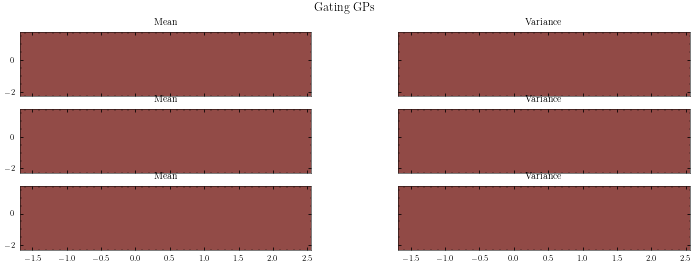

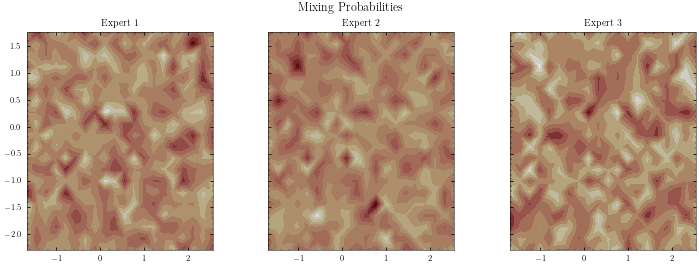

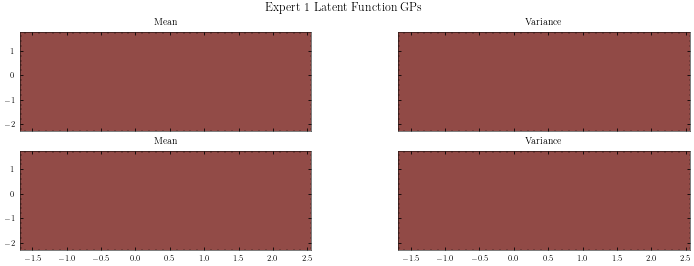

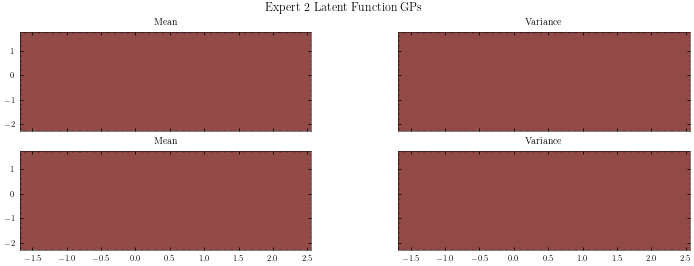

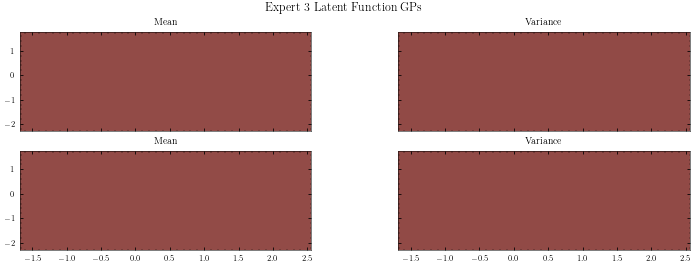

In [15]:
plot_model(model_three_experts)

In [16]:
num_epochs = 3000
batch_size = 16
learning_rate = 0.01
num_samples = 1  # number of samples to draw from variational posterior in ELBO
# ckpt_dir = "./ckpts"
# log_dir = "./logs"

In [17]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model_three_experts.compile(optimizer=optimizer)

In [18]:
# history = model_three_experts.fit(X, Y, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
history = model_three_experts.fit(X, Y, epochs=num_epochs, batch_size=batch_size)

2022-02-15 15:08:44.290024: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3000
Instructions for updating:
Use fn_output_signature instead
Mixing probs: (1, 16, 3)
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Experts probs: (1, 16, 3)


2022-02-15 15:08:48.014476: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Mixing probs: (1, 16, 3)
Experts probs: (1, 16, 3)
40/40 [==============================] - 17s 5ms/step - loss: 46.4738
Epoch 2/3000
40/40 [==============================] - 0s 4ms/step - loss: 38.2642
Epoch 3/3000
40/40 [==============================] - 0s 7ms/step - loss: 32.4497
Epoch 4/3000
40/40 [==============================] - 0s 8ms/step - loss: 28.0350
Epoch 5/3000
40/40 [==============================] - 0s 9ms/step - loss: 24.0657
Epoch 6/3000
40/40 [==============================] - 0s 8ms/step - loss: 20.0188
Epoch 7/3000
40/40 [==============================] - 0s 8ms/step - loss: 17.1508
Epoch 8/3000
40/40 [==============================] - 0s 9ms/step - loss: 16.0480
Epoch 9/3000
40/40 [==============================] - 0s 8ms/step - loss: 14.8102
Epoch 10/3000
40/40 [==============================] - 0s 7ms/step - loss: 14.2508
Epoch 11/3000
40/40 [==============================] - 0s 7ms/step - loss: 14.1263
Epoch 12/3000
40/40 [==============================] - 0s

40/40 [==============================] - 0s 10ms/step - loss: 6.7604
Epoch 98/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7041
Epoch 99/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7017
Epoch 100/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7753
Epoch 101/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5550
Epoch 102/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4457
Epoch 103/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2369
Epoch 104/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3502
Epoch 105/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4694
Epoch 106/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5693
Epoch 107/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7087
Epoch 108/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4582
Epoch 109/30

40/40 [==============================] - 0s 11ms/step - loss: 6.1708
Epoch 196/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5195
Epoch 197/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1641
Epoch 198/3000
40/40 [==============================] - 1s 13ms/step - loss: 6.5418
Epoch 199/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5858
Epoch 200/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0317
Epoch 201/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.2400
Epoch 202/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.1944
Epoch 203/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6448
Epoch 204/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5481
Epoch 205/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4063
Epoch 206/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5990
Epoch 207/30

40/40 [==============================] - 0s 9ms/step - loss: 6.3493
Epoch 294/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2204
Epoch 295/3000
40/40 [==============================] - 0s 9ms/step - loss: 7.0295
Epoch 296/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5662
Epoch 297/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4451
Epoch 298/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3379
Epoch 299/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0945
Epoch 300/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.4800
Epoch 301/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.2240
Epoch 302/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6520
Epoch 303/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7983
Epoch 304/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4842
Epoch 305/30

40/40 [==============================] - 0s 11ms/step - loss: 6.4193
Epoch 392/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2018
Epoch 393/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.9442
Epoch 394/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6566
Epoch 395/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1820
Epoch 396/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3880
Epoch 397/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2419
Epoch 398/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1184
Epoch 399/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2307
Epoch 400/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4228
Epoch 401/3000
40/40 [==============================] - 0s 11ms/step - loss: 5.9129
Epoch 402/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4165
Epoch 40

40/40 [==============================] - 0s 9ms/step - loss: 6.1205
Epoch 490/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0529
Epoch 491/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4694
Epoch 492/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3560
Epoch 493/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5669
Epoch 494/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5732
Epoch 495/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.1683
Epoch 496/3000
40/40 [==============================] - 1s 13ms/step - loss: 6.6069
Epoch 497/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.4893
Epoch 498/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.0820
Epoch 499/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3839
Epoch 500/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2755
Epoch 501/30

40/40 [==============================] - 0s 10ms/step - loss: 6.3201
Epoch 588/3000
40/40 [==============================] - 0s 10ms/step - loss: 5.9886
Epoch 589/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3029
Epoch 590/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6796
Epoch 591/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2002
Epoch 592/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5445
Epoch 593/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4725
Epoch 594/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3801
Epoch 595/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5204
Epoch 596/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3941
Epoch 597/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4460
Epoch 598/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0297
Epoch 599/3

40/40 [==============================] - 0s 8ms/step - loss: 6.4316
Epoch 686/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4061
Epoch 687/3000
40/40 [==============================] - 0s 9ms/step - loss: 5.9740
Epoch 688/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5469
Epoch 689/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4622
Epoch 690/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5275
Epoch 691/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2933
Epoch 692/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.3833
Epoch 693/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6410
Epoch 694/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4347
Epoch 695/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4020
Epoch 696/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.1328
Epoch 697/3000
40/4

40/40 [==============================] - 0s 10ms/step - loss: 6.4293
Epoch 784/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5543
Epoch 785/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.1722
Epoch 786/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2648
Epoch 787/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7050
Epoch 788/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2317
Epoch 789/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.1510
Epoch 790/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2032
Epoch 791/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5182
Epoch 792/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7634
Epoch 793/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1744
Epoch 794/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5848
Epoch 795/3000

40/40 [==============================] - 0s 10ms/step - loss: 6.6216
Epoch 882/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.9321
Epoch 883/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4826
Epoch 884/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2281
Epoch 885/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.8445
Epoch 886/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4180
Epoch 887/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1130
Epoch 888/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2015
Epoch 889/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6700
Epoch 890/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2804
Epoch 891/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3834
Epoch 892/3000
40/40 [==============================] - 0s 10ms/step - loss: 7.0265
Epoch 893/30

40/40 [==============================] - 0s 12ms/step - loss: 5.9619
Epoch 980/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.2372
Epoch 981/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.4490
Epoch 982/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.4578
Epoch 983/3000
40/40 [==============================] - 0s 12ms/step - loss: 5.7926
Epoch 984/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.3719
Epoch 985/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.0674
Epoch 986/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.7408
Epoch 987/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.4745
Epoch 988/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.7685
Epoch 989/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.5593
Epoch 990/3000
40/40 [==============================] - 1s 17ms/step - loss: 6.3012
Epoch 9

40/40 [==============================] - 0s 10ms/step - loss: 6.1439
Epoch 1076/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5620
Epoch 1077/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.1900
Epoch 1078/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4708
Epoch 1079/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6028
Epoch 1080/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1306
Epoch 1081/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4754
Epoch 1082/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6267
Epoch 1083/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6231
Epoch 1084/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5059
Epoch 1085/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3433
Epoch 1086/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2878

40/40 [==============================] - 0s 8ms/step - loss: 6.3152
Epoch 1173/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4111
Epoch 1174/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.1228
Epoch 1175/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4194
Epoch 1176/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4610
Epoch 1177/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.8174
Epoch 1178/3000
40/40 [==============================] - 0s 9ms/step - loss: 5.9643
Epoch 1179/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3644
Epoch 1180/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5217
Epoch 1181/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2045
Epoch 1182/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0428
Epoch 1183/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.0640
Epoch 11

40/40 [==============================] - 0s 10ms/step - loss: 5.9912
Epoch 1270/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1367
Epoch 1271/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4542
Epoch 1272/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7442
Epoch 1273/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0718
Epoch 1274/3000
40/40 [==============================] - 0s 10ms/step - loss: 5.8351
Epoch 1275/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4920
Epoch 1276/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1877
Epoch 1277/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5001
Epoch 1278/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3654
Epoch 1279/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6933
Epoch 1280/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4595


40/40 [==============================] - 0s 8ms/step - loss: 6.3178
Epoch 1367/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5895
Epoch 1368/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2315
Epoch 1369/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.7460
Epoch 1370/3000
40/40 [==============================] - 0s 8ms/step - loss: 5.9139
Epoch 1371/3000
40/40 [==============================] - 0s 9ms/step - loss: 5.9035
Epoch 1372/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5658
Epoch 1373/3000
40/40 [==============================] - 0s 9ms/step - loss: 5.9889
Epoch 1374/3000
40/40 [==============================] - 0s 9ms/step - loss: 5.9771
Epoch 1375/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.1199
Epoch 1376/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.0802
Epoch 1377/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4762
Epoch 13

40/40 [==============================] - 0s 8ms/step - loss: 6.5752
Epoch 1464/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.9537
Epoch 1465/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.9513
Epoch 1466/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3239
Epoch 1467/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2975
Epoch 1468/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6115
Epoch 1469/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3675
Epoch 1470/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3991
Epoch 1471/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7066
Epoch 1472/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2249
Epoch 1473/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.0249
Epoch 1474/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.1491
Epoch 14

40/40 [==============================] - 0s 9ms/step - loss: 6.3022
Epoch 1561/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2515
Epoch 1562/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6026
Epoch 1563/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.3675
Epoch 1564/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.1546
Epoch 1565/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2926
Epoch 1566/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3895
Epoch 1567/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1769
Epoch 1568/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0918
Epoch 1569/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7431
Epoch 1570/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6256
Epoch 1571/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4480
Epoch 1

40/40 [==============================] - 0s 10ms/step - loss: 6.2680
Epoch 1658/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7926
Epoch 1659/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3279
Epoch 1660/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6235
Epoch 1661/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0562
Epoch 1662/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2929
Epoch 1663/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0222
Epoch 1664/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.7001
Epoch 1665/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.2786
Epoch 1666/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.4717
Epoch 1667/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.2048
Epoch 1668/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.0057

40/40 [==============================] - 0s 9ms/step - loss: 6.3713
Epoch 1755/3000
40/40 [==============================] - 0s 10ms/step - loss: 5.9232
Epoch 1756/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4007
Epoch 1757/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0195
Epoch 1758/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7175
Epoch 1759/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0951
Epoch 1760/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0735
Epoch 1761/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5270
Epoch 1762/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3400
Epoch 1763/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3273
Epoch 1764/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6053
Epoch 1765/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2234
Epo

40/40 [==============================] - 0s 9ms/step - loss: 6.1945
Epoch 1852/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6065
Epoch 1853/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.5373
Epoch 1854/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.1880
Epoch 1855/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4859
Epoch 1856/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3262
Epoch 1857/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2850
Epoch 1858/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4607
Epoch 1859/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3352
Epoch 1860/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5731
Epoch 1861/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3328
Epoch 1862/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5031
Epoch 

40/40 [==============================] - 0s 8ms/step - loss: 6.3404
Epoch 1949/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.5547
Epoch 1950/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4190
Epoch 1951/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6601
Epoch 1952/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2246
Epoch 1953/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2794
Epoch 1954/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2742
Epoch 1955/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5031
Epoch 1956/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3912
Epoch 1957/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.5214
Epoch 1958/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.1271
Epoch 1959/3000
40/40 [==============================] - 0s 8ms/step - loss: 5.9372
Epoch 19

40/40 [==============================] - 0s 11ms/step - loss: 6.0331
Epoch 2046/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.5267
Epoch 2047/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6931
Epoch 2048/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.6524
Epoch 2049/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3126
Epoch 2050/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.3784
Epoch 2051/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.6690
Epoch 2052/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4980
Epoch 2053/3000
40/40 [==============================] - 0s 10ms/step - loss: 5.9326
Epoch 2054/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5477
Epoch 2055/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2227
Epoch 2056/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.7533

40/40 [==============================] - 0s 10ms/step - loss: 6.1591
Epoch 2143/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.6817
Epoch 2144/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.6595
Epoch 2145/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1349
Epoch 2146/3000
40/40 [==============================] - 0s 10ms/step - loss: 5.9366
Epoch 2147/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.3548
Epoch 2148/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.0048
Epoch 2149/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.6410
Epoch 2150/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5233
Epoch 2151/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7524
Epoch 2152/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3741
Epoch 2153/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4394

40/40 [==============================] - 0s 10ms/step - loss: 6.1316
Epoch 2240/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.0311
Epoch 2241/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4392
Epoch 2242/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7922
Epoch 2243/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2131
Epoch 2244/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.2067
Epoch 2245/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.1537
Epoch 2246/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.4082
Epoch 2247/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.5138
Epoch 2248/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.7323
Epoch 2249/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0047
Epoch 2250/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.3187
Ep

40/40 [==============================] - 0s 10ms/step - loss: 6.3930
Epoch 2337/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.5146
Epoch 2338/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.5940
Epoch 2339/3000
40/40 [==============================] - 1s 17ms/step - loss: 6.3771
Epoch 2340/3000
40/40 [==============================] - 1s 19ms/step - loss: 6.4040
Epoch 2341/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.1151
Epoch 2342/3000
40/40 [==============================] - 1s 16ms/step - loss: 6.5806
Epoch 2343/3000
40/40 [==============================] - 1s 19ms/step - loss: 6.5328
Epoch 2344/3000
40/40 [==============================] - 1s 19ms/step - loss: 6.3356
Epoch 2345/3000
40/40 [==============================] - 1s 17ms/step - loss: 6.3451
Epoch 2346/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.3817
Epoch 2347/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.5

40/40 [==============================] - 0s 9ms/step - loss: 6.3452
Epoch 2433/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6139
Epoch 2434/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6096
Epoch 2435/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.4149
Epoch 2436/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2782
Epoch 2437/3000
40/40 [==============================] - 0s 12ms/step - loss: 6.1251
Epoch 2438/3000
40/40 [==============================] - 0s 11ms/step - loss: 6.1783
Epoch 2439/3000
40/40 [==============================] - 0s 9ms/step - loss: 7.1812
Epoch 2440/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.0209
Epoch 2441/3000
40/40 [==============================] - 1s 14ms/step - loss: 6.8318
Epoch 2442/3000
40/40 [==============================] - 1s 13ms/step - loss: 6.5199
Epoch 2443/3000
40/40 [==============================] - 1s 13ms/step - loss: 6.5841
Epo

40/40 [==============================] - 0s 9ms/step - loss: 6.1790
Epoch 2529/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.9672
Epoch 2530/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.4636
Epoch 2531/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6096
Epoch 2532/3000
40/40 [==============================] - 0s 9ms/step - loss: 6.2285
Epoch 2533/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.2926
Epoch 2534/3000
40/40 [==============================] - 0s 8ms/step - loss: 6.6332
Epoch 2535/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2269
Epoch 2536/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.2732
Epoch 2537/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3674
Epoch 2538/3000
40/40 [==============================] - 0s 10ms/step - loss: 5.8825
Epoch 2539/3000
40/40 [==============================] - 0s 10ms/step - loss: 6.3974
Epo


KeyboardInterrupt



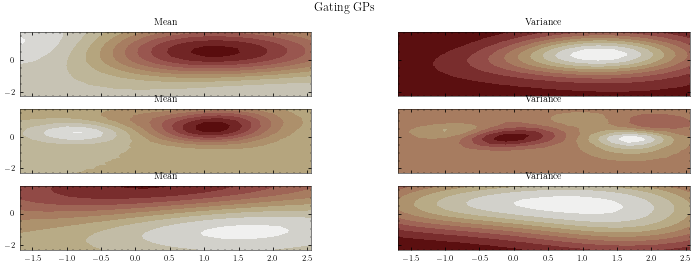

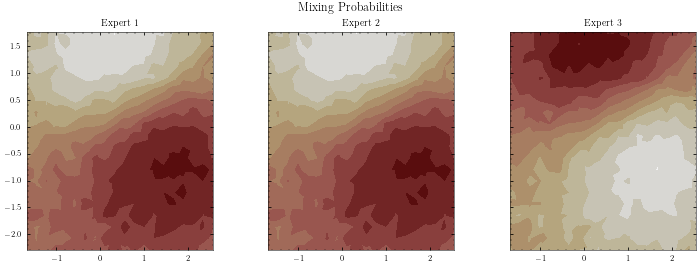

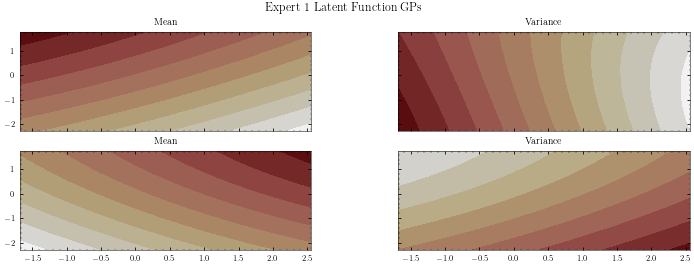

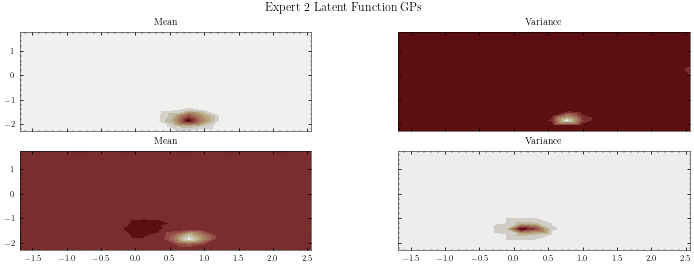

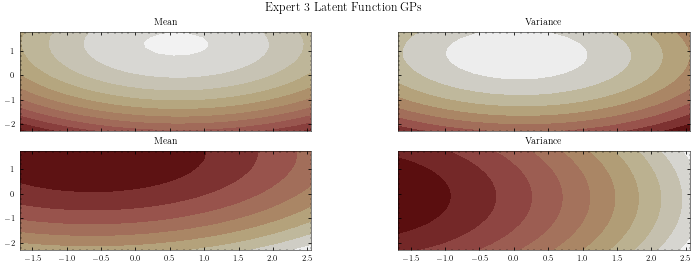

In [19]:
plot_model(model_three_experts)